In [2]:
%pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple pureml-evaluate
%pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple pureml
%pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple pureml-policy


Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple
  Using cached https://test-files.pythonhosted.org/packages/6a/ad/c405efd5d631c742e61f676d95404356e5cd7c6549938112305290f720f2/pureml_evaluate-0.0.3.2-py3-none-any.whl (152 kB)
  Using cached plotly-5.17.0-py2.py3-none-any.whl (15.6 MB)
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Using cached scipy-1.11.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Using cached pypdf2-3.0.1-py3-none-any.whl (232 kB)
  Using cached daisy-1.0-py3-none-any.whl (45 kB)
  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Using cached reportlab-4.0.6-py3-none-any.whl (1.9 MB)
  Using cached scikit_learn-1.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
  Using cached fairlearn-0.8.0-py3-none-any.whl (235 kB)
  Using cached pydantic-1.10.13-cp310-cp310-manylinux_2_17_x86_

In [ ]:
# use 'pureml auth login' to login to your account
# pureml init -- Need to Run this in command line
# puremlconfig.yaml file will be created in the current directory
# Make sure to restart the kernel after running the above commands for the changes to take effect

In [1]:
import pureml

pureml.__version__

'0.4.1.1'

In [2]:
import pureml_evaluate 

pureml_evaluate.__version__

'0.0.3.2'

In [3]:
import pureml_policy

pureml_policy.__version__

'0.0.1.1'

In [1]:
# Import all the required files
import pureml
from pureml.decorators import load_data,transformer,dataset,model
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings

warnings.simplefilter("ignore")
rand_seed = 1234
np.random.seed(rand_seed)

In [2]:
@load_data()
def load_dataset():
    df = pd.read_excel(io='default of credit card clients.xls',header  = 1)

    return df

In [3]:
@transformer()
def remove_columns(df):
    return df.drop(['ID'],axis =1)

In [4]:
@transformer()
def rename_columns(df):
    return df.rename(columns={"PAY_0": "PAY_1","default payment next month":"default"})    

In [5]:
@transformer()
def dataset_imbalances(df):
    categorical_features = ["SEX", "EDUCATION", "MARRIAGE"]

    for col_name in categorical_features:
        df[col_name] = df[col_name].astype("category")

    Y, A_str = df.loc[:, "default"], df.loc[:, "SEX"]
    X = pd.get_dummies(df.drop(columns=["default", "SEX"]))

    #A_str = A.map({1: "male", 2: "female"})

    A_str.value_counts(normalize=True)
    Y.value_counts(normalize=True)
    
    # Generate "Interest" column as a DataFrame_str
    interest_values = np.random.normal(loc=2 * Y, scale=A_str)
    interest_column = pd.DataFrame(interest_values, columns=["Interest"])

    # Concatenate "Interest" column with X DataFrame
    X = pd.concat([X, interest_column], axis=1)

    return {'X':X,'Y':Y,'A_str':A_str}


In [6]:
@transformer()
def resample_training_data(X_train, Y_train, A_train):
   
    negative_ids = Y_train[Y_train == 0].index
    positive_ids = Y_train[Y_train == 1].index
    balanced_ids = positive_ids.union(
        np.random.choice(a=negative_ids, size=len(positive_ids)))

    X_train = X_train.loc[balanced_ids, :]
    Y_train = Y_train.loc[balanced_ids]
    A_train = A_train.loc[balanced_ids]
    return  {"X_train": X_train, "Y_train":Y_train, "A_train": A_train}

In [7]:
from pureml.decorators import dataset

@dataset(label='credit_dataset_test_pypi2:main',upload=True)
def create_dataset():
    df = load_dataset()
    df = remove_columns(df)
    df = rename_columns(df)
    data  = dataset_imbalances(df)
    X,Y,A_str = data['X'],data['Y'],data['A_str']
    X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, Y, A_str, test_size=0.35, stratify=Y)
    data = resample_training_data(X_train, y_train, A_train)
    X_train, y_train, A_train = data['X_train'],data['Y_train'],data['A_train']
    A_test = A_test.to_numpy()
    y_test = y_test.to_numpy()
    return {"x_train":X_train,"y_train":y_train,"x_test":X_test,"y_test":y_test,"sensitive_features" : A_test}
    

create_dataset()

Dataset details have not been found

Dataset has been created!

 Connected to Branch

Hash :  9d01dd568024a9cd182ce230b185e11d

Version:  v1

Dataset label:  credit_dataset_test_pypi2:main:v1

Dataset and lineage have been registered!

{'x_train':        LIMIT_BAL  AGE  PAY_1  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  \
 0          20000   24      2      2     -1     -1     -2     -2       3913   
 1         120000   26     -1      2      0      0      0      2       2682   
 3          50000   37      0      0      0      0      0      0      46990   
 4          50000   57     -1      0     -1      0      0      0       8617   
 8         140000   28      0      0      2      0      0      0      11285   
 ...          ...  ...    ...    ...    ...    ...    ...    ...        ...   
 29973     230000   35      1     -2     -2     -2     -2     -2          0   
 29976      40000   47      2      2      3      2      2      2      52358   
 29981      50000   44      1      2      2      2      0      0      38671   
 29981      50000   44      1      2      2      2      0      0      38671   
 29982      90000   36      0      0      0      0      0      0       7752   
 
        BILL_AMT2  ...  EDUCATION_2  ED

In [8]:
data = pureml.dataset.fetch('credit_dataset_test_pypi2:main:v1')
x_test = data['x_test']
y_test = data['y_test']


In [9]:
from pureml.decorators import model
import pureml

@model(label='credit_example_test_pypi2:main')
def create_model():
    data = pureml.dataset.fetch('credit_dataset_test_pypi2:main:v1')
    x_train = data['x_train']
    y_train = data['y_train']
    lgb_params = {
    "metric": "auc",
    "learning_rate": 0.03,
    "num_leaves": 10,
    "max_depth": 3,
    "random_state": rand_seed,
    "n_jobs": 1}

    #pureml.log(params=lgb_params)
    estimator = Pipeline(
        steps=[
            ("preprocessing", StandardScaler()),
            ("classifier", lgb.LGBMClassifier(**lgb_params)),
        ]
    )

    estimator.fit(x_train, y_train)
    return estimator

create_model()

[LightGBM] [Info] Number of positive: 4313, number of negative: 4313
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.169618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3523
[LightGBM] [Info] Number of data points in the train set: 8626, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Model details have not been found

Model has been created!

model_created True

branch_exists True

Model has been registered!

Model Version:  v1

Model label:  credit_example_test_pypi2:main:v1

No metrics are found in config
No params are found in config
No figures are found in config


Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc',
                                n_jobs=1, num_leaves=10, random_state=1234))])

In [10]:
import pureml


pureml.model.fetch(label='credit_example_test_pypi2:main:v1')

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('classifier',
                 LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc',
                                n_jobs=1, num_leaves=10, random_state=1234))])

In [11]:
pureml.predict.add(label ='credit_example_test_pypi2:main:v1',paths={'predict':'predict.py'})

Predict Function has been registered!

{"status":200,"data":[{"key":"predict","data":"predict.py","model_version":{"uuid":"6cc5d24a-8716-4d4f-a106-aceea6a
28967","version":"v1"},"dataset_version":{"uuid":"00000000-0000-0000-0000-000000000000","version":""}}],"message":"
Logs created"}

In [12]:
import pureml

pureml.predict.fetch(label='credit_example_test_pypi2:main:v1')

 predict file predict.py has been fetched

In [13]:
faircredit = {'accuracy': 0.7,
    'precision' : 0.8,
    'recall'  : 0.8,
    'f1' : 0.7,
    'balanced_accuracy' : 0.8,
    'balanced_acc_error': 0.7}

 Succesfully fetched the dataset

 Succesfully fetched the predictor

 Succesfully fetched the model

Dataset Keys: dict_keys(['x_train', 'y_train', 'x_test', 'y_test', 'sensitive_features'])

Data in sensitive_features: [1 1 2 ... 2 2 1]

'balanced_accuracy'
argument of type 'NoneType' is not iterable
'balanced_acc_error'
argument of type 'NoneType' is not iterable


Dataset Keys: dict_keys(['x_train', 'y_train', 'x_test', 'y_test', 'sensitive_features'])

Data in sensitive_features: [1 1 2 ... 2 2 1]

'balanced_accuracy'
argument of type 'NoneType' is not iterable
'balanced_acc_error'
argument of type 'NoneType' is not iterable


Dataset Keys: dict_keys(['x_train', 'y_train', 'x_test', 'y_test', 'sensitive_features'])

Data in sensitive_features: [1 1 2 ... 2 2 1]

'balanced_accuracy'
argument of type 'NoneType' is not iterable
'balanced_acc_error'
argument of type 'NoneType' is not iterable


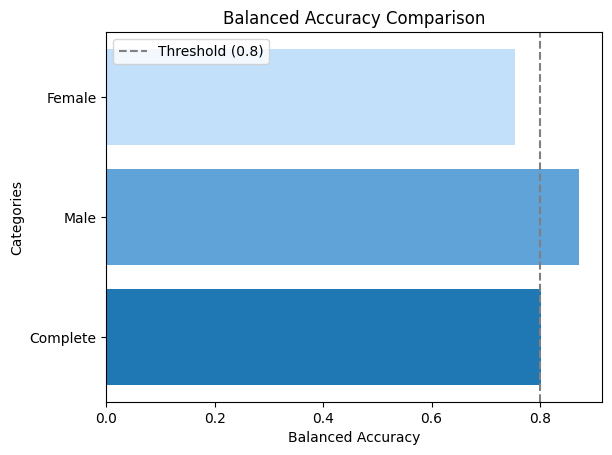

In [15]:
from pureml_policy import policy_eval
policy = faircredit
results = policy_eval.eval(policy  = policy,
            label_model='credit_example_test_pypi2:main:v1',
            label_dataset='credit_dataset_test_pypi2:main:v1')

Balanced Accuracy is a metric used to evaluate the performance of binary and multiclass classification models. It is particularly useful when dealing with imbalanced datasets where the classes are not equally represented.
Definition
Balanced accuracy is defined as the average of the proportion of actual positive instances that are correctly identified by the model (True Positive Rate or Sensitivity) and the proportion of actual negative instances that are correctly identified by the model (True Negative Rate or Specificity). Mathematically, it is represented as:

                Balanced Accuracy =  (Sensitivity + Specificity)/2

Importance in Fairness Models in Banks
When banks use predictive models, such as credit scoring models, fairness is crucial to ensure that all groups of people are treated equitably. In such models, balanced accuracy becomes essential due to the following reasons:

1. Handling Imbalanced Datasets:
In banking, the number of people who default on loans (negative class) is generally much lower than the number who do not default (positive class). Balanced accuracy helps ensure that the model’s performance is evaluated effectively across both classes.

2. Ensuring Fairness:
Balanced accuracy helps in assessing the model's performance across different demographic groups, ensuring that the model is not biased towards any particular group. It helps in identifying and mitigating any discrimination in the model’s predictions.

3. Regulatory Compliance:
Banks operate under stringent regulations to ensure fairness and non-discrimination in lending practices. Using balanced accuracy as a metric helps banks in demonstrating that their models are fair and compliant with regulations such as the Equal Credit Opportunity Act (ECOA).

4. Customer Trust:
A model that is fair and has a high balanced accuracy is more likely to gain customer trust, as it ensures that all customers, regardless of their background, are evaluated equitably for creditworthiness.

5. Comprehensive Evaluation:
Balanced accuracy allows for a more comprehensive evaluation of the model’s performance by considering both Type I and Type II errors, helping banks to make more informed and fair credit decisions.
Conclusion
Balanced accuracy is a valuable metric for banks to ensure that their predictive models, like those used in credit scoring, are fair, equitable, and free from biases against any particular group of customers. It helps in achieving a balance in model performance across various demographic groups, leading to more ethical and responsible lending practices.

In [17]:
results

{'model': 'credit_example_test_pypi2:main',
 'version': 'v1',
 'result': [{'complete': {'complete': {'operational': {'accuracy': 'fail',
      'precision': 'fail',
      'recall': 'pass',
      'f1': 'pass'},
     'fairness': {'balanced_accuracy': 'fail', 'balanced_acc_error': 'pass'},
     'operational_scores': {'accuracy': '0.7964761904761904',
      'precision': '0.8110202324580285',
      'recall': '0.525963149078727',
      'f1': '0.6381033022861982'},
     'fairness_scores': {'balanced_accuracy': '0.8016823065188516',
      'balanced_acc_error': '0.009093399225773232'},
     'operational_thresholds': {'accuracy': '0.7',
      'precision': '0.8',
      'recall': '0.8',
      'f1': '0.7'},
     'fairness_thresholds': {'balanced_accuracy': '0.8',
      'balanced_acc_error': '0.7'}}},
   'subsets': {1: {'operational': {'accuracy': 'fail',
      'precision': 'fail',
      'recall': 'pass',
      'f1': 'fail'},
     'fairness': {'balanced_accuracy': 'fail', 'balanced_acc_error': 'pass'

In [19]:
results['result'][0]['complete']

{'complete': {'operational': {'accuracy': 'fail',
   'precision': 'fail',
   'recall': 'pass',
   'f1': 'pass'},
  'fairness': {'balanced_accuracy': 'fail', 'balanced_acc_error': 'pass'},
  'operational_scores': {'accuracy': '0.7964761904761904',
   'precision': '0.8110202324580285',
   'recall': '0.525963149078727',
   'f1': '0.6381033022861982'},
  'fairness_scores': {'balanced_accuracy': '0.8016823065188516',
   'balanced_acc_error': '0.009093399225773232'},
  'operational_thresholds': {'accuracy': '0.7',
   'precision': '0.8',
   'recall': '0.8',
   'f1': '0.7'},
  'fairness_thresholds': {'balanced_accuracy': '0.8',
   'balanced_acc_error': '0.7'}}}

In [21]:
results['result'][0]['subsets'][1]

{'operational': {'accuracy': 'fail',
  'precision': 'fail',
  'recall': 'pass',
  'f1': 'fail'},
 'fairness': {'balanced_accuracy': 'fail', 'balanced_acc_error': 'pass'},
 'operational_scores': {'accuracy': '0.8690647482014389',
  'precision': '0.8757700205338809',
  'recall': '0.6674491392801252',
  'f1': '0.7575488454706927'},
 'fairness_scores': {'balanced_accuracy': '0.8713956485648128',
  'balanced_acc_error': '0.011913189792152125'},
 'operational_thresholds': {'accuracy': '0.7',
  'precision': '0.8',
  'recall': '0.8',
  'f1': '0.7'},
 'fairness_thresholds': {'balanced_accuracy': '0.8',
  'balanced_acc_error': '0.7'}}

In [22]:
results['result'][0]['subsets'][2]

{'operational': {'accuracy': 'fail',
  'precision': 'pass',
  'recall': 'pass',
  'f1': 'pass'},
 'fairness': {'balanced_accuracy': 'pass', 'balanced_acc_error': 'pass'},
 'operational_scores': {'accuracy': '0.7486571879936809',
  'precision': '0.7642698295033358',
  'recall': '0.4474826388888889',
  'f1': '0.5644675609088421'},
 'fairness_scores': {'balanced_accuracy': '0.7543493295278172',
  'balanced_acc_error': '0.012843157543219253'},
 'operational_thresholds': {'accuracy': '0.7',
  'precision': '0.8',
  'recall': '0.8',
  'f1': '0.7'},
 'fairness_thresholds': {'balanced_accuracy': '0.8',
  'balanced_acc_error': '0.7'}}